# Imports

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
# glob serves some of the same functions as ls in the terminal
import glob
from astropy.nddata import CCDData
import ccdproc as ccdp

from astropy import units as u
from astropy.table import Table

from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std


import warnings
warnings.filterwarnings("ignore")

## Convenience Functions

In [3]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.
    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


def image_snippet(image, center, width=50, axis=None, fig=None,
                  is_mask=False, pad_black=False, **kwargs):
    """
    Display a subsection of an image about a center.
    Parameters
    ----------
    image : numpy array
        The full image from which a section is to be taken.
    center : list-like
        The location of the center of the cutout.
    width : int, optional
        Width of the cutout, in pixels.
    axis : matplotlib.Axes instance, optional
        Axis on which the image should be displayed.
    fig : matplotlib.Figure, optional
        Figure on which the image should be displayed.
    is_mask : bool, optional
        Set to ``True`` if the image is a mask, i.e. all values are
        either zero or one.
    pad_black : bool, optional
        If ``True``, pad edges of the image with zeros to fill out width
        if the slice is near the edge.
    """
    if pad_black:
        sub_image = Cutout2D(image, center, width, mode='partial', fill_value=0)
    else:
        # Return a smaller subimage if extent goes out side image
        sub_image = Cutout2D(image, center, width, mode='trim')
    show_image(sub_image.data, cmap='gray', ax=axis, fig=fig,
               show_colorbar=False, show_ticks=False, is_mask=is_mask,
               **kwargs)


def _mid(sl):
    return (sl.start + sl.stop) // 2


def display_cosmic_rays(cosmic_rays, images, titles=None,
                        only_display_rays=None):
    """
    Display cutouts of the region around each cosmic ray and the other images
    passed in.
    Parameters
    ----------
    cosmic_rays : photutils.segmentation.SegmentationImage
        The segmented cosmic ray image returned by ``photuils.detect_source``.
    images : list of images
        The list of images to be displayed. Each image becomes a column in
        the generated plot. The first image must be the cosmic ray mask.
    titles : list of str
        Titles to be put above the first row of images.
    only_display_rays : list of int, optional
        The number of the cosmic ray(s) to display. The default value,
        ``None``, means display them all. The number of the cosmic ray is
        its index in ``cosmic_rays``, which is also the number displayed
        on the mask.
    """
    # Check whether the first image is actually a mask.

    if not ((images[0] == 0) | (images[0] == 1)).all():
        raise ValueError('The first image must be a mask with '
                         'values of zero or one')

    if only_display_rays is None:
        n_rows = len(cosmic_rays.slices)
    else:
        n_rows = len(only_display_rays)

    n_columns = len(images)

    width = 12

    # The height below is *CRITICAL*. If the aspect ratio of the figure as
    # a whole does not allow for square plots then one ends up with a bunch
    # of whitespace. The plots here are square by design.
    height = width / n_columns * n_rows
    fig, axes = plt.subplots(n_rows, n_columns, sharex=False, sharey='row',
                             figsize=(width, height))

    # Generate empty titles if none were provided.
    if titles is None:
        titles = [''] * n_columns

    display_row = 0

    for row, s in enumerate(cosmic_rays.slices):
        if only_display_rays is not None:
            if row not in only_display_rays:
                # We are not supposed to display this one, so skip it.
                continue

        x = _mid(s[1])
        y = _mid(s[0])

        for column, plot_info in enumerate(zip(images, titles)):
            image = plot_info[0]
            title = plot_info[1]
            is_mask = column == 0
            ax = axes[display_row, column]
            image_snippet(image, (x, y), width=80, axis=ax, fig=fig,
                          is_mask=is_mask)
            if is_mask:
                ax.annotate('Cosmic ray {}'.format(row), (0.1, 0.9),
                            xycoords='axes fraction',
                            color='cyan', fontsize=20)

            if display_row == 0:
                # Only set the title if it isn't empty.
                if title:
                    ax.set_title(title)

        display_row = display_row + 1

    # This choice results in the images close to each other but with
    # a small gap.
    plt.subplots_adjust(wspace=0.1, hspace=0.05)

# Combining the Biases and the Darks and Flats

## Combining Biases

In [4]:
#This is how to add the units column so the example code doesn't flip. It is not efficient and should be done in a for loop but I freaked and just did it my own way
#bias = fits.open('./data/biases/Bias_BIN1_20230418_022847.fits')
#hdr = bias[0].header
#hdr['BUNIT'] = 'adu'
#bias.writeto('./data/biases/UNITS/Bias_BIN1_20230418_022847UNITS.fits')
#bias.close()

In [4]:
biasPath = Path('./data/biases/UNITS')
biases = ccdp.ImageFileCollection(biasPath)

In [15]:
calibratedBiases = biases.files_filtered(include_path=True)

#combinedBiases = ccdp.combine(calibratedBiases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combinedBiases.meta['combined'] = True

#combinedBiases.write(combinedCalibrationPath / 'combined_BiasesMedian.fit')

INFO:astropy:splitting each image into 25 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 25 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


[973.0, 975.0, 976.0, 976.0, 976.0, 976.0, 976.0, 976.0, 977.0, 976.0, 1118.0, 977.0, 1118.0, 976.2727272727273]


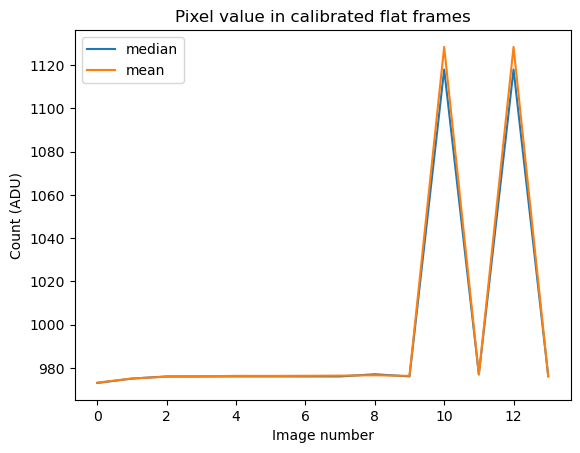

In [16]:
median_count = [np.median(data) for data in biases.data()]
mean_count = [np.mean(data) for data in biases.data()]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

## Combining Flats

In [17]:
hAlphaPath = Path('./data/flats/HalphaFlat/UNITS')
hAlphaFlats = ccdp.ImageFileCollection(hAlphaPath)

[19769.666666666668, 19097.0, 20079.0, 20119.0]


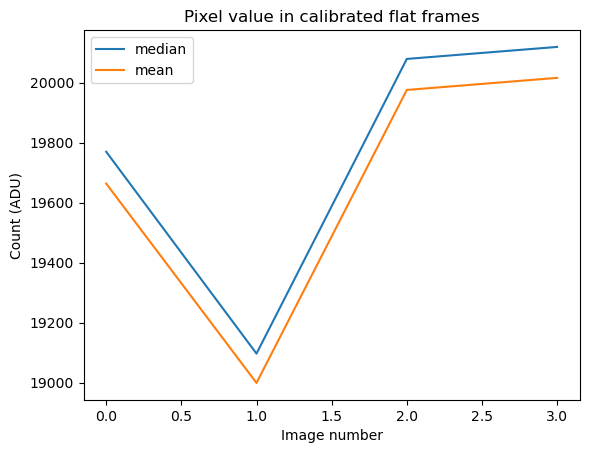

In [18]:
median_count = [np.median(data) for data in hAlphaFlats.data()]
mean_count = [np.mean(data) for data in hAlphaFlats.data()]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

In [19]:
calibratedFlats = hAlphaFlats.files_filtered(include_path=True)

combinedFlats = ccdp.combine(calibratedFlats,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combinedFlats.meta['combined'] = True
combinedFlats.write(combinedCalibrationPath / 'combinedAlphaFlatsMedian.fit')

INFO:astropy:splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


## Combining Darks

In [20]:
darkPath = Path('./data/darks/UNITS')
darks = ccdp.ImageFileCollection(darkPath)

In [21]:
calibratedDarks = darks.files_filtered(include_path=True)

combinedDarks = ccdp.combine(calibratedDarks,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                            sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combinedDarks.meta['combined'] = True

combinedDarks.write(darkPath / 'combined_DarksMedian.fit')

INFO:astropy:splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# Reducing the Image

## Defining Nearest Dark Exposure

In [5]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, a_flat.header['exptime']))
        
    
    return closest_dark_exposure

## Applying Flats, Bias, and Darks

In [6]:
sciencePath = Path('./data/scienceImage/UNITS')
scienceImage = ccdp.ImageFileCollection(sciencePath)
#scienceImage.summary

In [7]:
combinedCalibrationPath = Path('./data/CombinedCalibrations')
calibrationImages = ccdp.ImageFileCollection(combinedCalibrationPath)
calibrationImages.summary

<Table masked=True length=5>
            file             simple bitpix ... egain         sbstdver      
           str28              bool  int32  ... object         object       
---------------------------- ------ ------ ... ------ ---------------------
      combinedAlphaFlats.fit   True    -64 ...     --                    --
combinedAlphaFlatsMedian.fit   True    -64 ...     --                    --
         combined_Biases.fit   True    -64 ...     --                    --
   combined_BiasesMedian.fit   True    -64 ...     --                    --
    combined_DarksMedian.fit   True    -64 ...    1.5 SBFITSEXT Version 1.0

In [8]:
combinedDarks = [ccd for ccd in calibrationImages.ccds(combined=True)][4]
combinedBiases = [ccd for ccd in calibrationImages.ccds(combined = True)][3]
combinedFlats = [ccd for ccd in calibrationImages.ccds(combined=True)][1]

In [9]:
ccdScience = [ccd for ccd in scienceImage.ccds(imagetyp = 'LIGHT')][0]
reduced = ccdp.subtract_bias(ccdScience, combinedBiases)
combinedDarks = ccdp.subtract_bias(combinedDarks, combinedBiases)
combinedFlats = ccdp.subtract_bias(combinedFlats, combinedBiases)

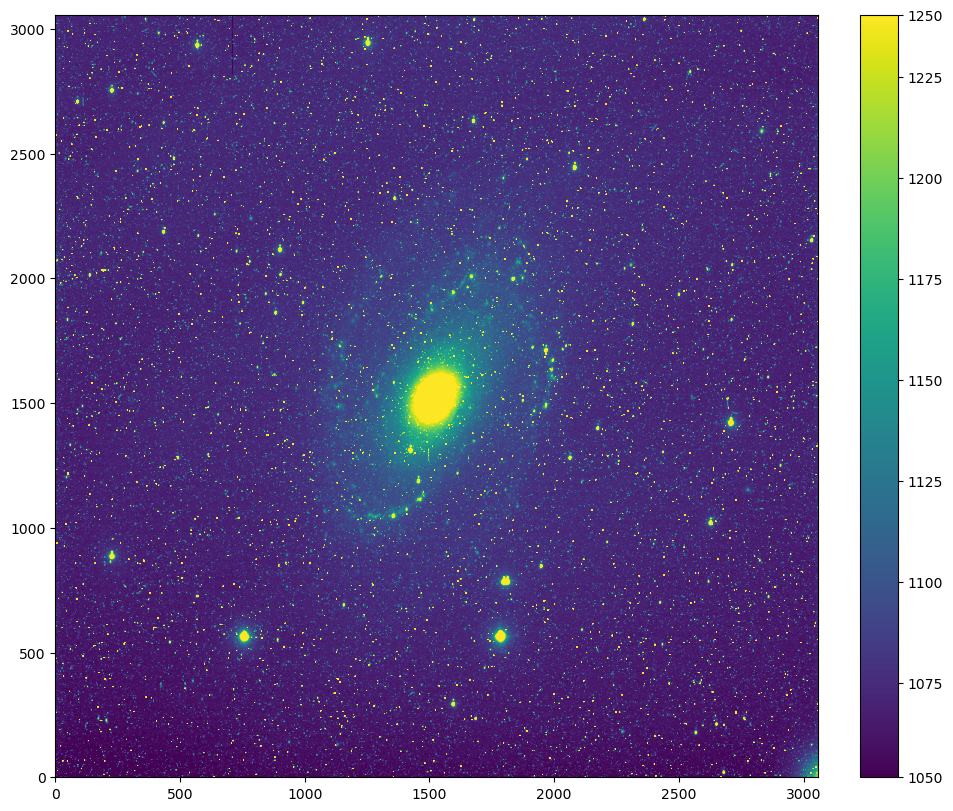

In [10]:
fig, axs = plt.subplots(
    figsize = (11, 8),
    constrained_layout = True
)
show_image(ccdScience, ax = axs, fig = fig)

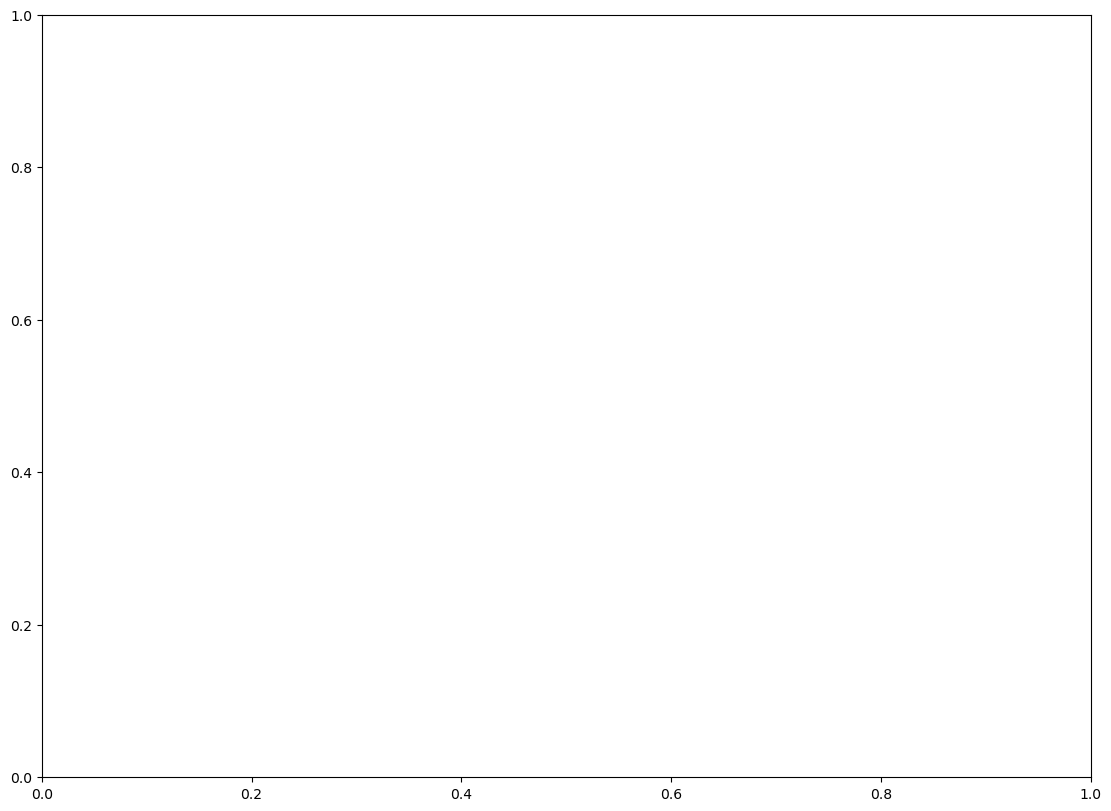

In [11]:
combinedFlats = ccdp.subtract_dark(combinedFlats, combinedDarks, exposure_time = 'exptime', exposure_unit = u.second, scale = True)
reduced = ccdp.subtract_dark(reduced, combinedDarks, exposure_time='exptime',exposure_unit = u.second)
fig, axs = plt.subplots(
    figsize = (11, 8),
    constrained_layout = True
)
#show_image(combinedFlats, ax = axs, fig = fig)

In [12]:
reduced = ccdp.flat_correct(reduced, combinedFlats)

## THE IMAGE

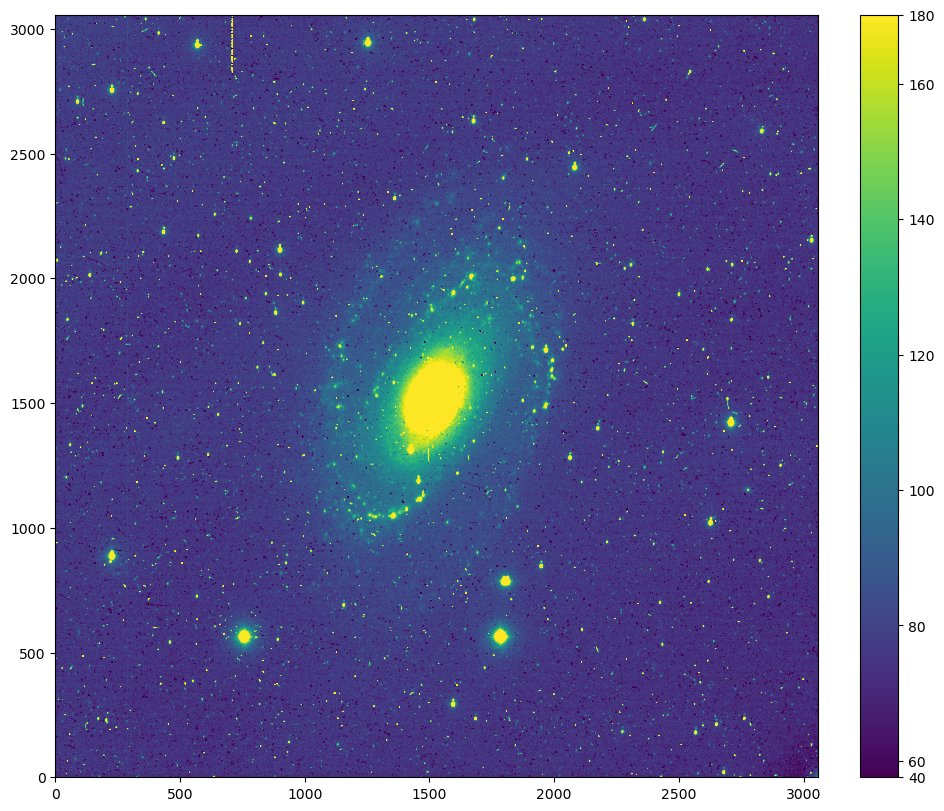

In [13]:
fig, axs = plt.subplots(
    figsize = (11, 8),
    constrained_layout = True
)
show_image(reduced, ax = axs, fig = fig)
#reducedPath = Path('./data/reducedImages')
#reduced.write(reducedPath / 'm81Reduced.fit')

# Using DAOStarFinder

## Aperture Photometry

In [14]:
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.aperture import aperture_photometry

from astropy.io import fits

In [22]:
m81 = np.asarray(reduced)
m81

array([[ 35.91651164,  87.90144808,  91.77206505, ..., 111.76010839,
        110.64117207,  88.65528917],
       [ 77.5319847 ,  70.26609067,  63.41512553, ..., 134.00362194,
        105.20982895,  64.3748452 ],
       [ 85.40054735,  65.79907773,  57.05955701, ...,  90.63661307,
         97.65483601, 105.93083648],
       ...,
       [ 91.25396072,  75.05558529,  85.10164914, ...,  87.49527681,
         91.48131125,  78.29965272],
       [ 59.46466756,  70.74948033,  78.88037503, ...,  72.37941578,
         64.94727688, 102.26822886],
       [ 61.53575703,  64.64541569,  81.6616533 , ...,  89.11356364,
         60.92614225,  59.21155842]])

In [23]:
bkgSigma = mad_std(m81)
daoFind = DAOStarFinder(fwhm = 3.0, threshold = 10.0 * bkgSigma)
mask = np.ones(m81.shape, dtype=bool)
mask[0:500, 0:500] = False
source= daoFind(m81, mask=mask)
source

<QTable length=41>
  id      xcentroid      ...        flux                mag         
int32      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    1 102.63691545697665 ...  2.308439004060439  -0.9082960091629483
    2 250.82394942264648 ... 2.7412448888311864  -1.0948695873140566
    3  489.8061871231058 ... 2.7330633888395965  -1.0916242613611788
    4  487.8771519153982 ...  1.546816503149809  -0.4735969923994243
    5  259.0717185475636 ... 1.6673295564769883  -0.5550536222662305
    6 257.37274012741204 ... 2.1229031890938157   -0.817325473638022
    7  409.8872077234682 ...  1.497582778287932   -0.438477092945671
    8  238.9721373557595 ...  2.083742434796578  -0.7971100902400464
    9 194.39347046203775 ...  7.124234183202136   -2.131845467180444
   10  441.9532953526807 ...  1.733838214849888  -0.5975214270893022
  ...                ... ...                ...                  ...
   32  424.0355885452766 ...  1.594205866053453  -0.5063610070763193
   33 204.20539184414278 ... 1.7662083664572064  -0.6176048441747953
   34 205.34291211568143 ... 2.4850798415449478  -0.9883508661596652
   35 464.63893501529503 ... 1.1448147095377963 -0.14683800241663209
   36  27.63574267491632 ...  6.398286422837494   -2.015159194041031
   37   67.5581804125257 ...  1.202093225305948 -0.19984537396289928
   38 138.05224267523212 ...  3.359964915836868  -1.3158368564671694
   39  330.2451072685365 ... 1.2565481317015816  -0.2479478219196733
   40 337.55704199025865 ...  1.654977573367503  -0.5469802825471192
   41  234.9759510565944 ... 3.1084182167494743  -1.2313486136486822

In [24]:
positions = np.transpose((source['xcentroid'], source['ycentroid']))  
apertures = CircularAperture(positions, r=4.0)  
phot_table = aperture_photometry(reduced, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  

 id  xcenter   ycenter  aperture_sum aperture_sum_err
       pix       pix        adu            adu       
--- --------- --------- ------------ ----------------
  1 102.63692 21.417119      5452.02        43.708587
  2 250.82395 42.141029    5609.4916        43.084506
  3 489.80619 44.583505     5707.527        42.988817
  4 487.87715 53.043146    5143.5694        43.685451
  5 259.07172 58.290692    5476.4152        45.584243
  6 257.37274 62.029687    5207.8023        45.469228
  7 409.88721 70.892299    4666.5186        43.248186
  8 238.97214 83.731959    5817.9834        44.720095
  9 194.39347 86.048723    8811.7398        48.445142
 10  441.9533 85.650186    5713.6407        44.035489
...       ...       ...          ...              ...
 32 424.03559 374.37965    9124.8854        44.714036
 33 204.20539 384.49826    5204.1424        41.997568
 34 205.34291  390.1292    5717.6169        42.317006
 35 464.63894 434.07233    4292.6873         79.98271
 36 27.635743 435.24959    8

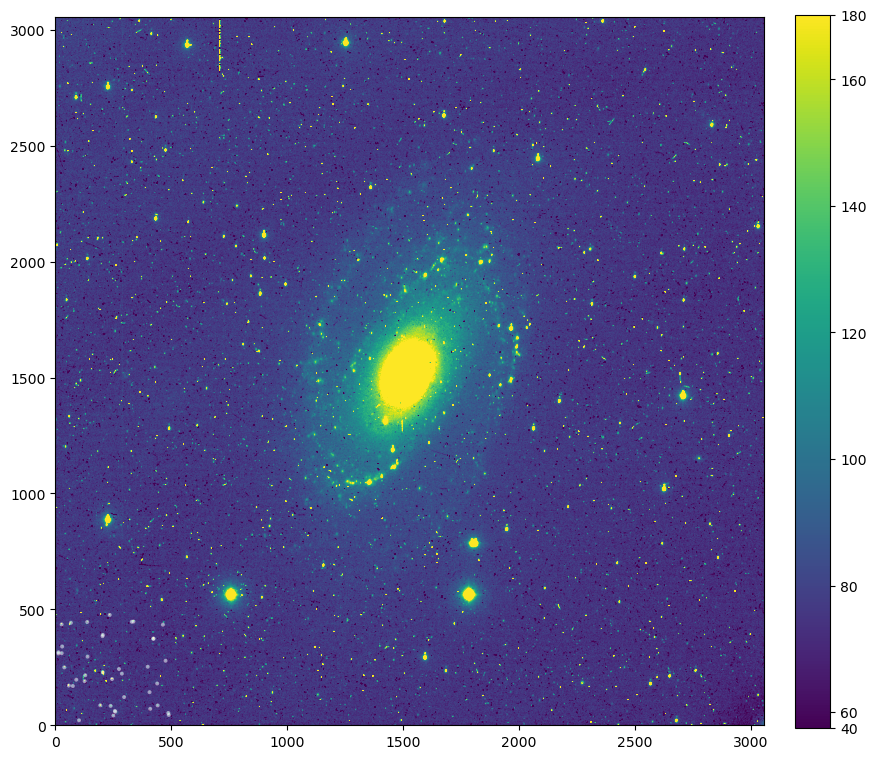

In [25]:
show_image(m81)
apertures.plot(color='w', lw=1.5, alpha=0.5);

## Circular Annulus

In [26]:
from photutils.aperture import CircularAnnulus

In [27]:
annulusInner = 4
annulusOuter = 8

annulusApert = CircularAnnulus(positions, r_in = annulusInner, r_out = annulusOuter)
annulusPhotometry = aperture_photometry(reduced, annulusApert)

annulusArea = np.pi * ((annulusOuter ** 2) - (annulusInner ** 2))
apertureArea = np.pi * (4**2) #The 4 comes from the previous part where I used 4 for the aperture radius
countPerArea = annulusPhotometry['aperture_sum'] / annulusArea
background = countPerArea * apertureArea
print(annulusPhotometry)
counts = annulusPhotometry['aperture_sum'] - background
print(counts)

 id      xcenter            ycenter          aperture_sum     aperture_sum_err 
           pix                pix                adu                adu        
--- ------------------ ------------------ ------------------ ------------------
  1 102.63691545697665  21.41711892248925 11296.076152344376  76.92182269332848
  2 250.82394942264648 42.141029012707605   9899.04820055977  315.8917711577776
  3  489.8061871231058 44.583504740973325 11721.593879633641  74.64452920298612
  4  487.8771519153982  53.04314607874073 11769.301286675274  71.40857686670998
  5  259.0717185475636  58.29069158445506 11963.591229352758 108.24131379221703
  6 257.37274012741204 62.029687232276004 12351.354157374335  77.85181068252712
  7  409.8872077234682  70.89229907013588 11281.827879358461  93.67967162900663
  8  238.9721373557595   83.7319586395999 12089.712315991601  77.08431672268269
  9 194.39347046203775  86.04872269642928  10174.59245493624  490.8609291867032
 10  441.9532953526807  85.6501859450180

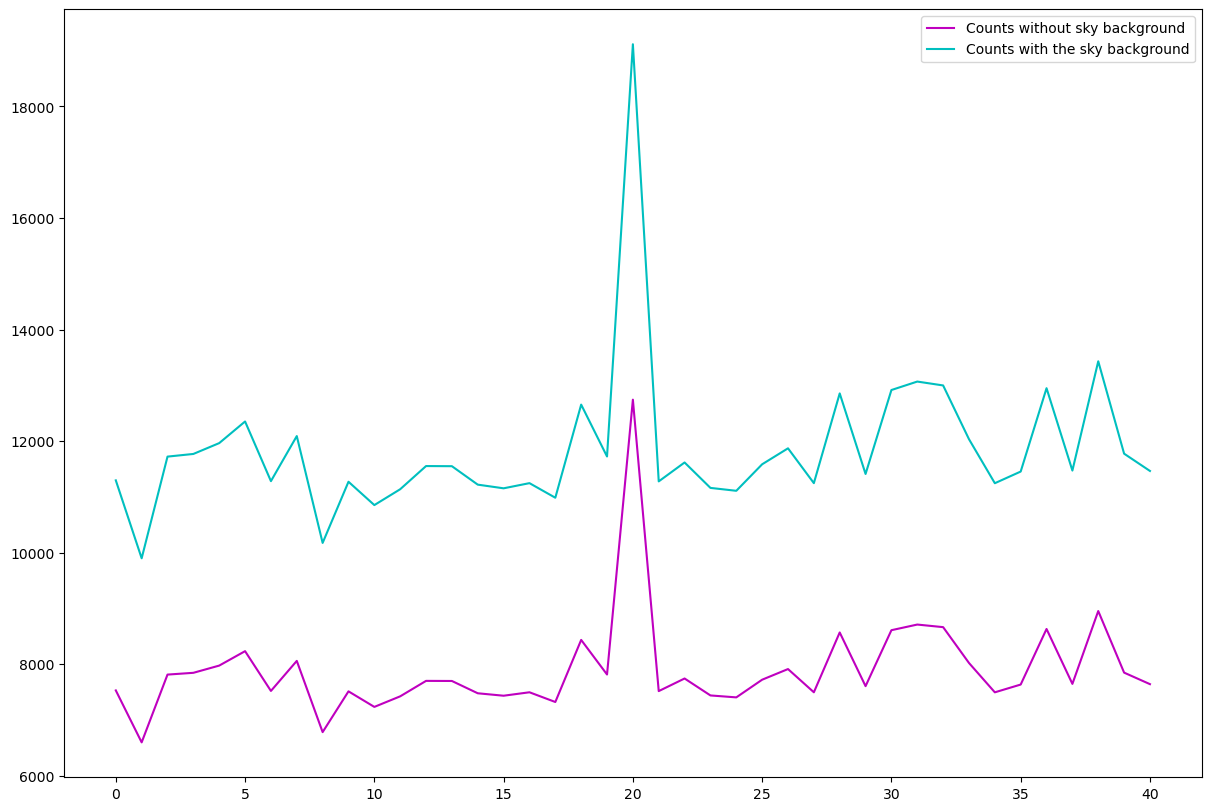

In [28]:
fig, ax = plt.subplots(
    figsize = (12, 8),
    constrained_layout = True
)
x = np.arange(0, len(annulusPhotometry['aperture_sum']), 1)
ax.plot(x, counts, color = 'm', label='Counts without sky background')
ax.plot(x, annulusPhotometry['aperture_sum'], color = 'c', label = 'Counts with the sky background')
ax.legend();

## Point Source Function

In [29]:
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, BasicPSFPhotometry

from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [30]:
sigmaPSF = 2.0
backgroundRMS = MADStdBackgroundRMS()
std = backgroundRMS(reduced)
irad = IRAFStarFinder(threshold = 3.5 * std,
                      fwhm = sigmaPSF * gaussian_sigma_to_fwhm,
                      minsep_fwhm = 0.01, roundhi = 5.0, roundlo = -5.0,
                      sharplo = 0.0, sharphi = 2.0)
daoGroup = DAOGroup (2.0 * sigmaPSF * gaussian_sigma_to_fwhm)
mmmBackground = MMMBackground()
levMarFitter = LevMarLSQFitter()

psfModel = IntegratedGaussianPRF(sigma = sigmaPSF)
psfModel.x_0.fixed = True
psfModel.y_0.fixed = True

pos = Table(names=['x_0', 'y_0'], data = [source['xcentroid'], source['ycentroid']])
photometry = BasicPSFPhotometry(group_maker = daoGroup,
                                bkg_estimator = mmmBackground,
                                psf_model = psfModel, 
                                fitter = LevMarLSQFitter(),
                                fitshape = (11,11))
psfPhot = photometry(image = m81, init_guesses = pos)
residual_image = photometry.get_residual_image()

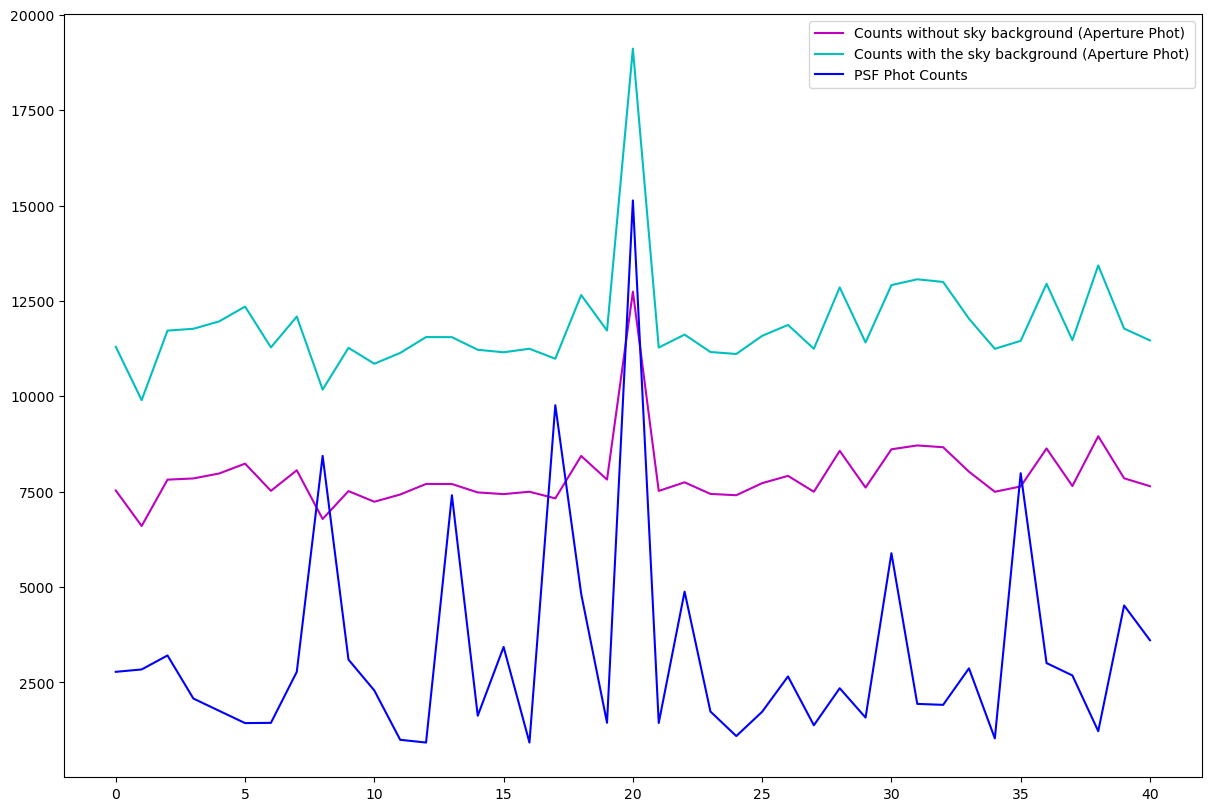

In [31]:
fig, ax = plt.subplots(
    figsize = (12,8),
    constrained_layout = True
)

x = np.arange(0, len(annulusPhotometry['aperture_sum']), 1)
ax.plot(x, counts, color = 'm', label='Counts without sky background (Aperture Phot)')
ax.plot(x, annulusPhotometry['aperture_sum'], color = 'c', label = 'Counts with the sky background (Aperture Phot)')
ax.plot(x, psfPhot['flux_fit'], label = 'PSF Phot Counts', color = 'b')
ax.legend();

# Try with M82

In [12]:
m82LightPath = Path('./m82Data/light')
m82Images = ccdp.ImageFileCollection(m82LightPath)

In [13]:
m82CalibrationPath = Path('./data/CombinedCalibrations/m82')

## Combining the flats

In [14]:
m82FlatPath = Path('./m82Data/flats/UNITS')
m82Flats = ccdp.ImageFileCollection(m82FlatPath)
#m82Flats.summary

In [22]:
calibratedFlats = m82Flats.files_filtered(include_path=True)

combinedFlats = ccdp.combine(calibratedFlats,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combinedFlats.meta['combined'] = True

combinedFlats.write(m82CalibrationPath / 'combinedFlatsM82.fit')

INFO:astropy:splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


## Reducing the data

In [15]:
combinedCalibrationPath = Path('./data/CombinedCalibrations')
combinedFlatsM82 = ccdp.ImageFileCollection(m82CalibrationPath)
calibrationImages = ccdp.ImageFileCollection(combinedCalibrationPath)
combinedFlatsM82.summary

<Table masked=True length=1>
        file         ...
       str20         ...
-------------------- ...
combinedFlatsM82.fit ...

In [16]:
combinedDarks = [ccd for ccd in calibrationImages.ccds(combined=True)][4]
combinedBiases = [ccd for ccd in calibrationImages.ccds(combined = True)][3]
combinedFlats = [ccd for ccd in combinedFlatsM82.ccds(combined=True)][0]

In [17]:
path = Path('./m82Data/light/UNITS')
scienceImage = ccdp.ImageFileCollection(path)
scienceImage.summary

<Table masked=True length=1>
              file              ...
             str31              ...
------------------------------- ...
M82_Halpha_20230419_050034.fits ...

## Subtracting Darks, Biases, and Flat Combining

In [18]:
ccdScience = [ccd for ccd in scienceImage.ccds(imagetyp = 'LIGHT', )][0]
reducedm82 = ccdp.subtract_bias(ccdScience, combinedBiases)
combinedDarks = ccdp.subtract_bias(combinedDarks, combinedBiases)
combinedFlats = ccdp.subtract_bias(combinedFlats, combinedBiases)

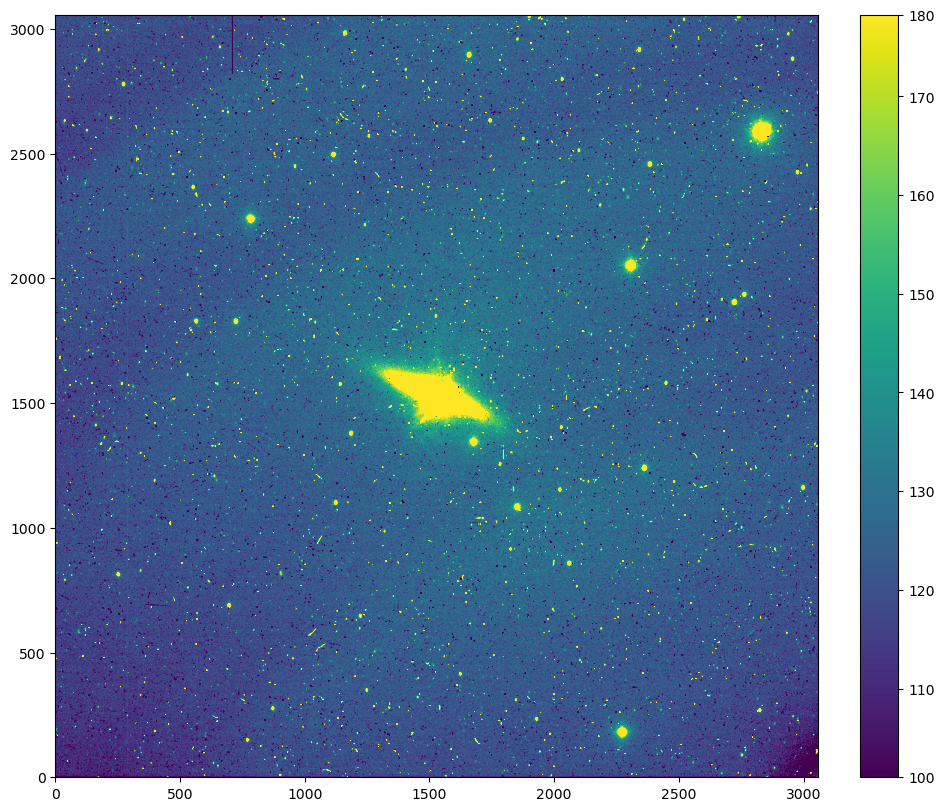

In [19]:
combinedFlats = ccdp.subtract_dark(combinedFlats, combinedDarks, exposure_time = 'exptime', exposure_unit = u.second, scale = True)
reducedm82 = ccdp.subtract_dark(reducedm82, combinedDarks, exposure_time='exptime',exposure_unit = u.second)
fig, axs = plt.subplots(
    figsize = (11, 8),
    constrained_layout = True
)

show_image(reducedm82, ax = axs, fig = fig)

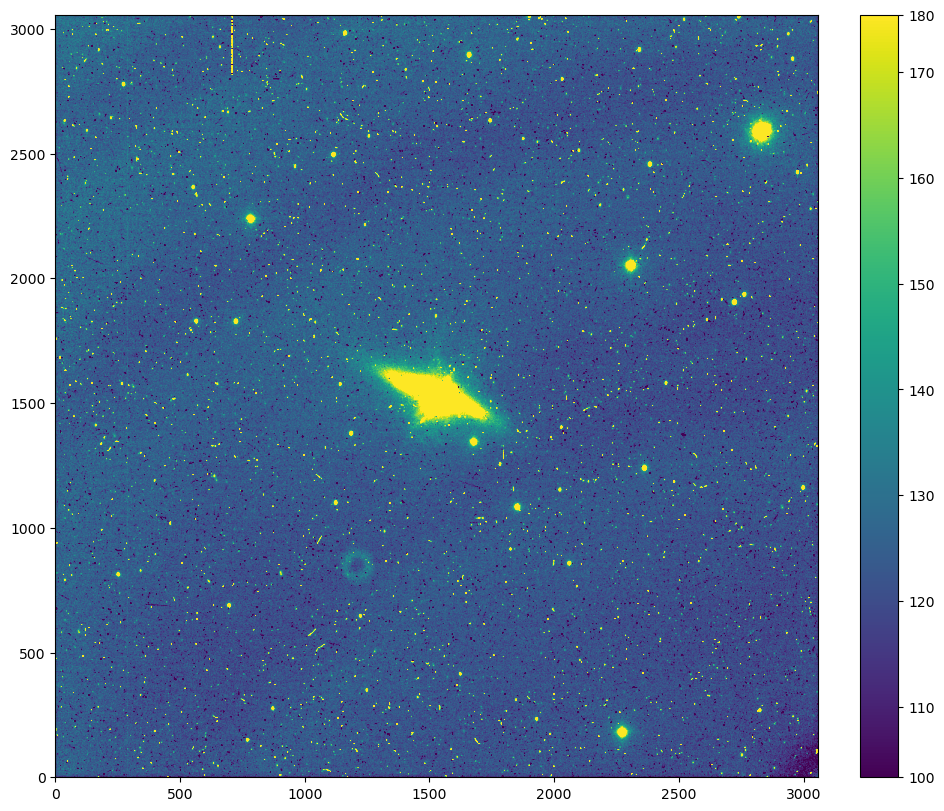

In [20]:
reducedm82 = ccdp.flat_correct(reducedm82, combinedFlats)
fig, axs = plt.subplots(
    figsize = (11, 8),
    constrained_layout = True
)

show_image(reducedm82, ax = axs, fig = fig)

# Finding SFR

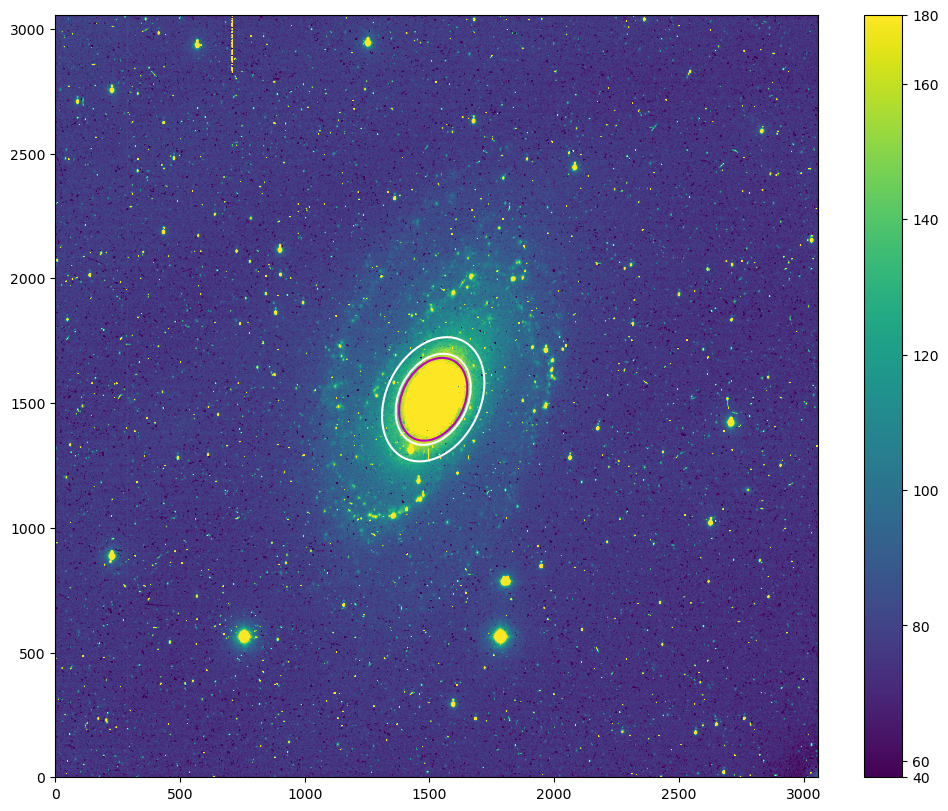

In [79]:
position = (1515,1515)
semiMajor = 175
semiMinor = 125
theta = 1.1
annulusInner = 1.1
annulusOuter = 1.5

ellipticalMask = EllipticalAperture(position, semiMajor, semiMinor, theta)
ellipticalAnnulus = EllipticalAnnulus(position, a_in = semiMajor * annulusInner, a_out = semiMajor * annulusOuter,
                                      b_in = semiMinor * annulusInner, b_out = semiMinor * annulusOuter, theta = theta)

fig, ax = plt.subplots(
    figsize = (12,8),
    constrained_layout = True
)
show_image(reduced, ax = ax, fig = fig)
ellipticalMask.plot(color = 'm', lw = 1.5)
ellipticalAnnulus.plot(color = 'w', lw = 1.5);

In [80]:
aperturePhot = aperture_photometry(reduced, ellipticalMask)
annulusPhot = aperture_photometry(reduced, ellipticalAnnulus)

# Find the count per area in the annulus to get the sky background
annulus_area = np.pi * semiMajor * semiMinor * ((annulusOuter ** 2) - (annulusInner ** 2))
aperture_area = np.pi * semiMajor * semiMinor
annulus_count_per_m2 = annulusPhot['aperture_sum'] / annulus_area

# Subtract the sky background from the aperture photometry
sky_background = annulus_count_per_m2 * aperture_area
adjusted_counts = aperturePhot['aperture_sum'] - sky_background
print(sky_background, adjusted_counts, aperturePhot['aperture_sum'])

[9385062.70596762] adu [9491839.82244593] adu [18876902.52841355] adu


In [81]:
aperturePhot = aperture_photometry(reduced, ellipticalMask)
annulusPhot = aperture_photometry(reduced, ellipticalAnnulus)

annulusArea = np.pi * semiMajor * semiMinor * ((annulusOuter**2)-(annulusInner**2))
apertureArea = np.pi * semiMajor * semiMinor

annulusCountM2 = annulusPhot['aperture_sum'] / annulusArea

skyBackground = annulusCountM2 * apertureArea
skyAdjust = aperturePhot['aperture_sum']# - skyBackground
print(skyBackground)
print(skyAdjust)
print(aperturePhot['aperture_sum'])

[9385062.70596762] adu
[18876902.52841355] adu
[18876902.52841355] adu


## Star Formation Rate

In [82]:
adu = u.def_unit('adu')
gain = 1.5 * (1/u.adu)

electrons = (skyAdjust[0] * gain) / 1800 #Gain of 1.5 and an exposure of 1800
photons = electrons / 0.7 #0.7 is quantum efficiency 
wavelength = 656.46E-9 
distance = 3.61 * 3.0856776E+22

hc = 1.986E-25
photonEnergy = (hc/wavelength)
fluxDensity = (photons * photonEnergy) / (np.pi * (0.5**2))
luminosity = fluxDensity * 4 * np.pi * (distance ** 2)
luminosity = luminosity * 10000000
print(luminosity)

1.3497642001051747e+40


In [83]:
sfr = 7.9 * (10 ** -42) * luminosity
print(f'SFR :{sfr:.2e} solar masses per year')

SFR :1.07e-01 solar masses per year
